# Calculating features

Training a neural network from scratch takes a lot of computational resources and enough, roughly balanced training data. Alternatively, one can use a __pretrained__ neural network and use it as a __feature extractor__.
`Keras` offers multiple pretrained models, that are mostly trained on imagenet, a database of natural images from 1000 classes.

This notebook loads such a model, removes its classification layer and adds a pooling layer such that the output is a feature vector instead of a classification result. These features are later going to be classified with a "non-deep" approach, such as an SVM or RF.

A set of features is stored as Pandas Dataframe with columns `id`, `label` and `features`. 

Again, __every region is treated separately__, i.e. gets its own dataframe of features and its own pickle file.
This might seem a little impractical and clumsy but has two advantages in this context:

1. Feature calculation is of course faster on smaller subsets. When trying new models or new parameters, features can be computed on a region with few roofs first.
2. Datasets are have different classification "difficulties". E.g. `mixco_3` is a small set that has no "incomplete" or "other" samples and only correctly labeled data. Thus, the pipeline can be tested on easy and more difficult sets.

In [1]:
from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
from keras.preprocessing import image
#from keras.applications.resnet50 import ResNet50 #--- good
#from keras.applications.resnet50 import preprocess_input

from keras.applications.mobilenet import MobileNet #--- good
from keras.applications.mobilenet import preprocess_input

#from keras.applications.vgg16 import VGG16 #--- ok-ish
#from keras.applications.vgg16 import preprocess_input

import numpy as np
from os.path import join, exists
from os import makedirs, walk
import pickle
import json
import time
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## 0. Choose region to work on

In [4]:
sets = [('colombia', 'borde_rural'),
        ('colombia', 'borde_soacha'),
        ('guatemala', 'mixco_1_and_ebenezer'), 
        ('guatemala', 'mixco_3'),
        ('st_lucia', 'dennery')
        #('st_lucia', 'gros_islet'), 
        #('st_lucia', 'castries')
       ]
country, region = sets[3]

In [5]:
train_dir = join('..', '..', 'stac', country, region, 'roofs_train')
test_dir = join('..', '..', 'stac', country, region, 'roofs_test')
materials = {'concrete_cement':0, 'healthy_metal':1, 'incomplete':2, 'irregular_metal':3, 'other':4}

pickle_path = join('..', '..', 'features')
if not exists(pickle_path):
    makedirs(pickle_path)

## 1. Load the model

Use a pretrained network to compute features from the images, which are later classified. Import the model from the Keras library and remove the top layer by setting `include_top=False`. The last layer is pooled using either `avg` or `max`-pooling such that we get outputs of size e.g. `[1, 2048]` (for ResNet50) instead of `[7, 7, 2048]`.

Some pretrained networks feature the possibility to choose the shape of input images. Larger inputs allow to work with more details, smaller inputs make the feature extraction faster.

In [6]:
#HEIGHT, WIDTH, CHANNELS = 224, 224, 3
HEIGHT, WIDTH, CHANNELS = 128, 128, 3
POOLING_METHOD = 'avg'

In [27]:
MODEL_TYPE = MobileNet

In [8]:
model = MODEL_TYPE(weights='imagenet',
                  include_top=False, pooling=POOLING_METHOD,
                  input_shape=(HEIGHT, WIDTH, CHANNELS))
model.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32) 

## 2. Calculate features on the training data

The preprocessed data is stored in such a way, that every region has their own folder, that contains a subfolder defined as `train_dir` above. This folder again is subdivided by material. Images carry their `id` as filename.

Every `train_dir` has a file `simple_labels.json`, that stores all `id`s of that region and their labels.
Traverse all images in this list of labels to assemble one big tensor with all the images of that region.

In [ ]:
model_name = model.name.split('_')[0]

In [9]:
with open(join(train_dir, 'simple_labels.json')) as label_file:
    labels_dict = json.load(label_file)
    
labels_list = []
for label_string in labels_dict.values():
    labels_list.append(materials[label_string])

    
train_data = np.zeros([len(labels_dict), HEIGHT, WIDTH, CHANNELS])
i = 0
for roof_id, roof_material in labels_dict.items(): 
    img_fp = join(train_dir, roof_material, roof_id+'.tif')
    
    # Adjust the image size to fit the network input
    img = image.load_img(img_fp, target_size=(HEIGHT, WIDTH))
    img_data = image.img_to_array(img)
    train_data[i] = img_data

    i = i+1
    
# Use the respective preprocessing function of the selected pretrained network
# to prepare it for the prediction step
train_data = preprocess_input(train_data)

In [10]:
train_data.shape

(158, 128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


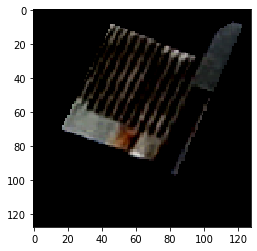

In [11]:
plt.imshow(train_data[-1])

Use `model.predict()` to extract the features of the preassembled batch:

In [13]:
start = time.time()
features_train = model.predict(train_data)

print(f'Feature extraction took {time.time()-start} seconds')

with open(join(pickle_path, f'{model_name}_{HEIGHT}_{POOLING_METHOD}_{region}_train.pkl' ), 'wb') as f:
    pickle.dump(features_train, f)

Feature extraction took 107.97122812271118 seconds


Save the computed features to file

In [14]:
with open(join(pickle_path, f'{model_name}_{HEIGHT}_{POOLING_METHOD}_{region}_train.pkl' ), 'rb') as f:
    features_train = pickle.load(f)

## 3. Visualize discriminativeness

In order to visualize how well the extracted features discriminate the classes, the dimensionality of the feature vector can be reduced to 2 using the tSNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

In [15]:
features_train.shape

(158, 1024)

In [16]:
np.bincount(labels_list)

array([51, 51,  0, 47,  9])

In [17]:
def plot_tsne(features, labels, title=None):
    
    tsne = TSNE(n_components=2, n_jobs=10).fit_transform(features)
    tsne_df = pd.DataFrame({'X':tsne[:,0],
                            'Y':tsne[:,1],
                            'label':labels})
    
    plt.figure(figsize=(10, 10))
    ax = sns.scatterplot(x="X", y="Y", hue="label",
                        palette="muted", s=100,
                        data=tsne_df);
    if title:
        ax.set_title(title, fontsize=16)

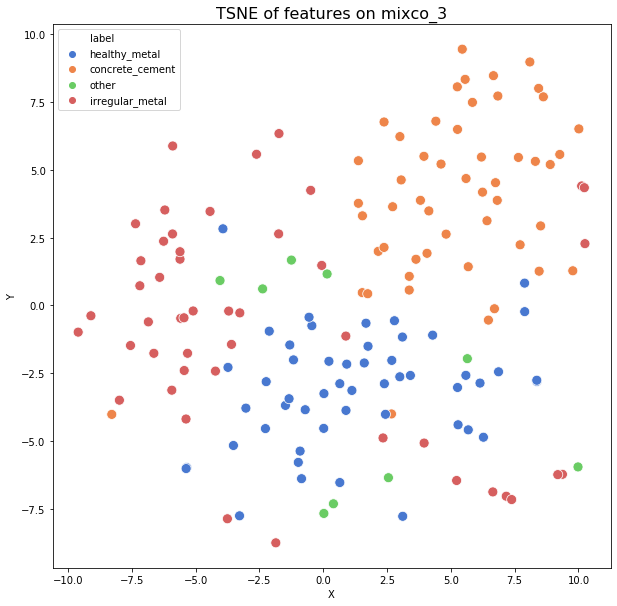

In [18]:
plot_tsne(features_train, list(labels_dict.values()), title=f'TSNE of features on {region}')

## 4. Reduce the number of features with PCA

Networks produce a lot features, many of which might be irrelevant for the separation of roof material classes. 
The principal component analysis computes the directions/components in which the dataset exposes the highest variance.

In [19]:
pca = PCA()
pca.fit(features_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Plotting the singular values shows how much influence components have in the dataset. The first singular values being much larger than the rest indicates that those components might be enough to separate the dataset.

In [20]:
pca.singular_values_.shape

(158,)

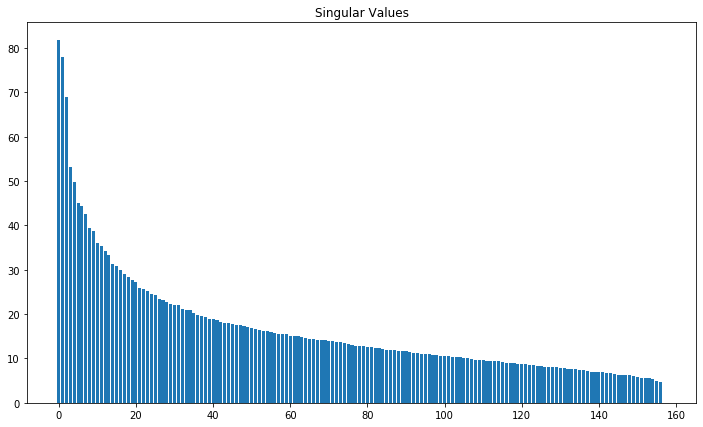

In [21]:
plt.figure(figsize=[12, 7])
plt.bar(range(pca.singular_values_.shape[0]), pca.singular_values_)
plt.title("Singular Values")
plt.show()

Select the top x components of the PCA and project the extracted features onto these components. This removes all the components except the "most relevant" ones.

In [22]:
top_x = 50
top_pc = pca.components_[:50]
features_proj = np.matmul(np.matmul(top_pc.T, top_pc), features_train.T).T

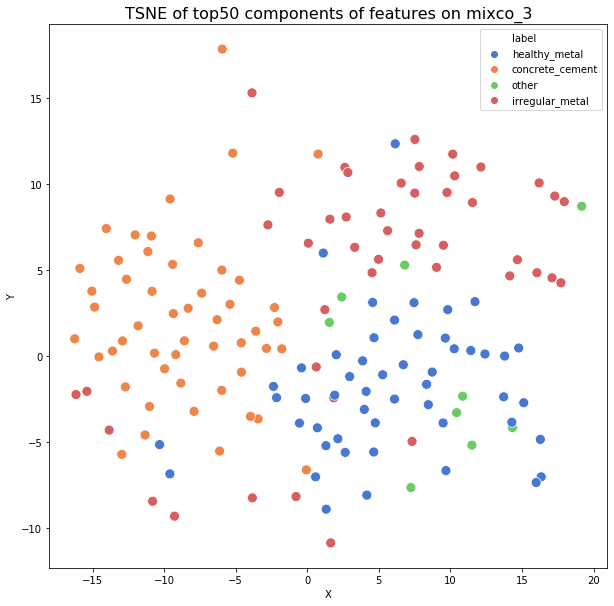

In [23]:
plot_tsne(features_proj, list(labels_dict.values()),
          title=f'TSNE of top{top_x} components of features on {region}')

## 5. Calculate features of the testset

In [24]:
for root, dirs, files in walk(test_dir, topdown=False):
    
    test_data = np.zeros([len(files), HEIGHT, WIDTH, CHANNELS])
    
    i = 0
    for name in files:
        img_fp = join(root, name)
    
        # Adjust the image size to fit the network input
        img = image.load_img(img_fp, target_size=(HEIGHT, WIDTH))
        img_data = image.img_to_array(img)
        test_data[i] = img_data
        i = i+1

In [25]:
test_data.shape

(58, 128, 128, 3)

In [26]:
start = time.time()
features_train = model.predict(train_data)

print(f'Feature extraction took {time.time()-start} seconds')

with open(join(pickle_path, f'{model_name}_{HEIGHT}_{POOLING_METHOD}_{region}_test.pkl' ), 'wb') as f:
    pickle.dump(features_train, f)

Feature extraction took 95.16485500335693 seconds
